In [1]:
import time
import scipy.io as scio
import numpy as np
from multiprocessing import Pool
import sys
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
from MDPD import utils, readers, MDPD

## Utilities

In [2]:
def show_img(arrays, figsize=None):
    "show image(s) in parallel"
    n = len(arrays)
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    for i in xrange(n):
        plt.subplot(n,1,i+1)
        plt.imshow(arrays[i].reshape((28,28)))
    plt.show()

## Read Data

In [3]:
folder = "/media/vzhao/Data/MNIST"
# folder = "/Users/vincent/Documents/Research/MDPD/MNIST"
mnist = readers.MNIST_Reader(folder, binarized=True)
train, labels = mnist.train, mnist.labels
_, dim, _ = train.shape

Extracting /media/vzhao/Data/MNIST/train-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/train-labels-idx1-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /media/vzhao/Data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# data per digit
train_uni = [None] * 10
for dig in xrange(10):
    train_uni[dig] = train[labels==dig,...]
# small sample
train_small = train[:2000,...]
labels_small = labels[:2000]

### Pick a data source

In [5]:
data, labs = train_small, labels_small

## Information residue as in raw data

MDPD/utils.py:228: RuntimeWarning: divide by zero encountered in log
  log_second = np.log(second)
MDPD/utils.py:229: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (log_second - log_first)


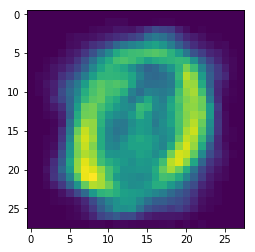

Information residue in raw data
0.00281335565268727
CPU times: user 467 ms, sys: 323 ms, total: 789 ms
Wall time: 320 ms


In [6]:
%%time
score_origin = utils.Feature_Selection.MI_score(data, rm_diag=True)
sigma_origin = score_origin.sum(axis=1)
show_img([sigma_origin])
print 'Information residue in raw data'
print sigma_origin.mean() / (dim - 1)

#### Reference G score

In [7]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * data.shape[0]) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.0028362166825360927, 0.001953681975812794, 0.0015628471577925807, 0.001027086233908079, 0.0005914934710938344]


### Mutual Information Residue if ues the labels as the posterior distribution

In [8]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(labs,labs.max()+1)
utils.log_replace_neginf(log_post)

/home/vzhao/.virtualenvs/tf/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [9]:
%%time
score, weighted = MDPD.utils.Feature_Selection.MI_score_conditional(data, log_post, rm_diag=True)
sigma_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(sigma_condition * weighted[np.newaxis, :]) / (dim * (dim - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.00351993080509271
CPU times: user 7.28 s, sys: 3.11 s, total: 10.4 s
Wall time: 5.11 s


#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

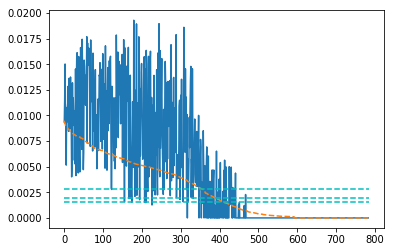

In [11]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in [0]:
    plt.plot(sigma_condition[idx,k]/(dim-1))
plt.plot(sigma_origin[idx] / (dim-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

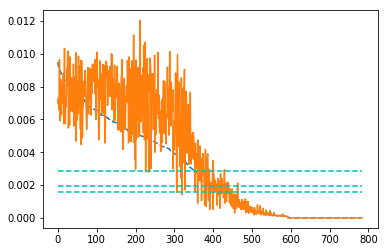

In [12]:
plt.figure()
plt.plot(sigma_origin[idx] / (dim-1), '--')
plt.plot(np.sum(sigma_condition[idx, ...] * weighted[np.newaxis, :], axis=1) / (dim-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

#### [Plot] Mutual information residue conditional on a digit vs Raw MIS

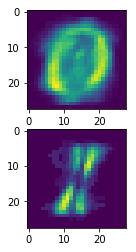

In [27]:
show_img([sigma_origin, sigma_condition[:,1]])

#### Conditional MIS vs Raw MIS

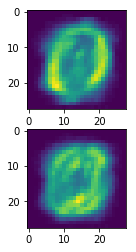

In [21]:
show_img([sigma_origin, np.sum(sigma_condition * weighted[np.newaxis, :], axis=1)])

#### Conclusion

A naive mixture model is not a good generative model of MNIST data set.

## Train a MDPD with the selected features

In [22]:
%%time
features, _ = utils.Feature_Selection.MI_feature_ranking(data)

CPU times: user 389 ms, sys: 204 ms, total: 593 ms
Wall time: 237 ms


#### Top Ntop features

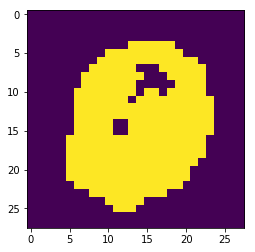

In [23]:
Ntop = 300
img = np.zeros(dim)
img[features[:Ntop]] = 1
show_img([img])

In [24]:
%%time
model1 = MDPD.MDPD()
model1.fit(data, ncomp=10, init='random', verbose=True, features=features[:Ntop], epoch=50)

2018-04-05 16:52:18,875 : INFO : Training an MDPD with dimension 784, 300 features, sample size 2000, vocab size 2 and the target number of components 10
2018-04-05 16:52:20,216 : INFO : iteration 0; log-likelihood (feature selection) -151.375826; log_likelihood -183.222071
2018-04-05 16:52:21,540 : INFO : iteration 1; log-likelihood (feature selection) -139.539997; log_likelihood -169.523546
2018-04-05 16:52:22,862 : INFO : iteration 2; log-likelihood (feature selection) -137.661748; log_likelihood -167.022021
2018-04-05 16:52:24,157 : INFO : iteration 3; log-likelihood (feature selection) -136.903456; log_likelihood -166.058839
2018-04-05 16:52:25,449 : INFO : iteration 4; log-likelihood (feature selection) -136.246111; log_likelihood -165.326045
2018-04-05 16:52:26,759 : INFO : iteration 5; log-likelihood (feature selection) -135.659251; log_likelihood -164.622597
2018-04-05 16:52:28,047 : INFO : iteration 6; log-likelihood (feature selection) -135.175870; log_likelihood -164.024795

CPU times: user 52.3 s, sys: 11.6 s, total: 1min 3s
Wall time: 1min 4s


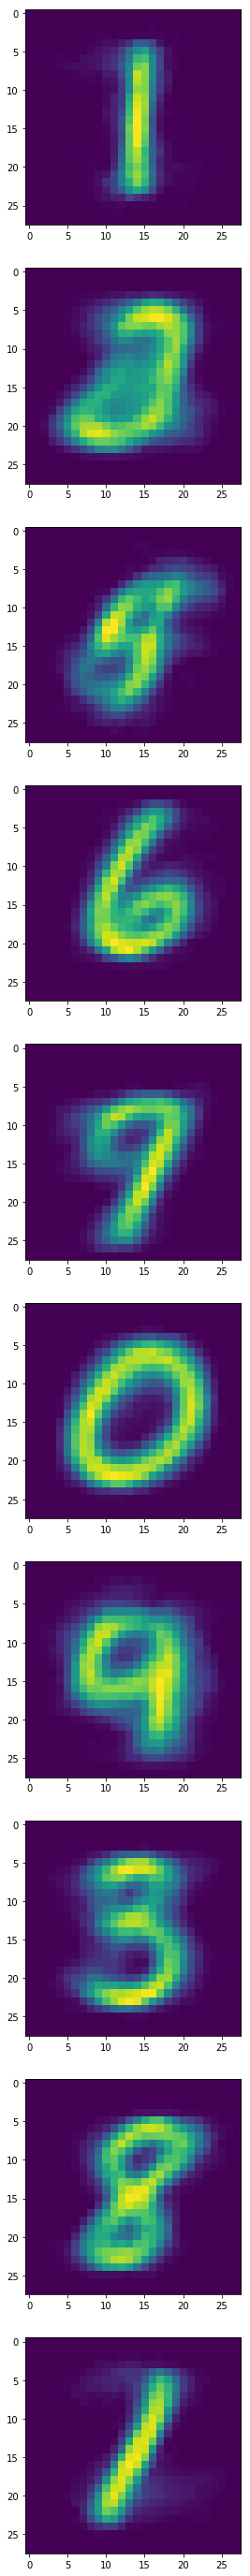

In [25]:
show_img(np.exp([model1.logC[:,0,i] for i in xrange(10)]), figsize=(50,50))

In [ ]:
model1.logC.shape

In [ ]:
img = np.zeros(dim)
img[features[:Ntop]] = np.exp(model1.logC[:,0,1])
plt.imshow(img.reshape((28,28)))

In [ ]:
foo.shape